In [169]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV

In [102]:
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 100)

In [154]:
data = pd.read_csv("shot_logs_with_physics_safe.csv")
data.columns = data.columns.str.lower()

In [155]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127974 entries, 0 to 127973
Data columns (total 27 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   game_id                     127974 non-null  int64  
 1   matchup                     127974 non-null  object 
 2   location                    127974 non-null  object 
 3   w                           127974 non-null  object 
 4   final_margin                127974 non-null  int64  
 5   shot_number                 127974 non-null  int64  
 6   period                      127974 non-null  int64  
 7   game_clock                  127974 non-null  object 
 8   shot_clock                  122415 non-null  float64
 9   dribbles                    127974 non-null  int64  
 10  touch_time                  127974 non-null  float64
 11  shot_dist                   127974 non-null  float64
 12  pts_type                    127974 non-null  int64  
 13  shot_result   

In [156]:
data.dropna(subset=["shot_clock"], inplace=True)

In [157]:
def feetToMeter(dt):
    return dt*0.3048

def heightToCM(x):
    if not isinstance(x, str):
        return None
    
    try:
        feet, inches = x.split('-')
        return float(feet) * 30.48 + float(inches) * 2.54
    except:
        return None


    

In [158]:
data["shot_dist_m"] = data["shot_dist"].apply(feetToMeter)
data["result"] = data["shot_result"].apply(lambda x : 1 if x == "made" else 0)
data["is_critical"] = data["final_margin"].apply(lambda x : 1 if abs(x) <= 10 else 0)
data["shot_clock_isSlope"] = data["shot_clock"].apply(lambda x : 0 if x > 5.0 else (1/25) * (x-5) * (x-5))
#data["wingspan_rate"] = data["shooter_wingspan"]/data["defender_wingspan"]
data["shooter_height_cm"] = data["shooter_height"].apply(feetToCM)
data["defender_height_cm"] = data["defender_height"].apply(feetToCM)
data["shooter_height_cm"].fillna(data["shooter_height_cm"].mean(), inplace=True)
data["defender_height_cm"].fillna(data["defender_height_cm"].mean(), inplace=True)
data["defender_wingspan_cm"] =  data["defender_wingspan"].apply(lambda x : x*2.54)
data["shooter_wingspan_cm"] =  data["shooter_wingspan"].apply(lambda x : x*2.54)
##constant
wingspan_ratio = data["defender_wingspan_cm"].mean()/data["defender_height_cm"].mean()
data["shooter_wingspan_cm"].fillna(data["shooter_height_cm"]*wingspan_ratio, inplace=True)
data["defender_wingspan_cm"].fillna(data["defender_height_cm"]*wingspan_ratio, inplace=True)
data["is_home"] = data["location"].apply(lambda x : 1 if x == "H" else 0)
data["shot_zone_label"] = data.apply(lambda row: 3 if row["pts_type"] == 3 else (2 if row["shot_dist_m"] > 10 else 1), axis=1)
data["ratio_wingspan_def_of"] = data.apply(lambda row: row["shooter_wingspan_cm"]/row["defender_wingspan_cm"] , axis=1)


C:\Users\User\AppData\Local\Temp\ipykernel_14852\869350511.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data["shooter_height_cm"].fillna(data["shooter_height_cm"].mean(), inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_14852\869350511.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always

In [159]:
data.head()


,game_id,matchup,location,w,final_margin,shot_number,period,game_clock,shot_clock,dribbles,touch_time,shot_dist,pts_type,shot_result,closest_defender,closest_defender_player_id,close_def_dist,fgm,pts,player_name,player_id,shooter_height,shooter_weight,shooter_wingspan,defender_height,defender_weight,defender_wingspan,shot_dist_m,result,is_critical,shot_clock_isSlope,shooter_height_cm,defender_height_cm,defender_wingspan_cm,shooter_wingspan_cm,is_home,shot_zone_label,ratio_wingspan_def_of
0,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,1,1,1:09,10.8,2,1.9,7.7,2,made,"Anderson, Alan",101187,1.3,1,2,brian roberts,203148,6-1,173.0,NaN,6-6,220.0,NaN,2.34696,1,0,0.0000,185.42,198.12,207.262597,193.976533,0,1,0.935897
1,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,2,1,0:14,3.4,0,0.8,28.2,3,missed,"Bogdanovic, Bojan",202711,6.1,0,0,brian roberts,203148,6-1,173.0,NaN,6-7,226.0,NaN,8.59536,0,0,0.1024,185.42,200.66,209.919810,193.976533,0,3,0.924051
3,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,4,2,11:47,10.3,2,1.9,17.2,2,missed,"Brown, Markel",203900,3.4,0,0,brian roberts,203148,6-1,173.0,NaN,6-3,190.0,80.75,5.24256,0,0,0.0000,185.42,190.50,205.105000,193.976533,0,1,0.945743
4,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,5,2,10:34,10.9,2,2.7,3.7,2,missed,"Young, Thaddeus",201152,1.1,0,0,brian roberts,203148,6-1,173.0,NaN,6-8,225.0,83.50,1.12776,0,0,0.0000,185.42,203.20,212.090000,193.976533,0,1,0.914595
5,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,6,2,8:15,9.1,2,4.4,18.4,2,missed,"Williams, Deron",101114,2.6,0,0,brian roberts,203148,6-1,173.0,NaN,6-3,200.0,78.25,5.60832,0,0,0.0000,185.42,190.50,198.755000,193.976533,0,1,0.975958


In [162]:
data.drop(columns=["game_id","matchup","location","w","final_margin","shot_number","game_clock","shot_dist","shot_result","closest_defender","closest_defender_player_id","fgm","pts","player_name","player_id","shooter_height","shooter_weight","shooter_wingspan","defender_height","defender_weight","defender_wingspan"], inplace=True)


In [163]:
data.isnull().sum()

period                   0
shot_clock               0
dribbles                 0
touch_time               0
pts_type                 0
close_def_dist           0
shot_dist_m              0
result                   0
is_critical              0
shot_clock_isSlope       0
shooter_height_cm        0
defender_height_cm       0
defender_wingspan_cm     0
shooter_wingspan_cm      0
is_home                  0
shot_zone_label          0
ratio_wingspan_def_of    0
dtype: int64

In [164]:
data.head()

,period,shot_clock,dribbles,touch_time,pts_type,close_def_dist,shot_dist_m,result,is_critical,shot_clock_isSlope,shooter_height_cm,defender_height_cm,defender_wingspan_cm,shooter_wingspan_cm,is_home,shot_zone_label,ratio_wingspan_def_of
0,1,10.8,2,1.9,2,1.3,2.34696,1,0,0.0000,185.42,198.12,207.262597,193.976533,0,1,0.935897
1,1,3.4,0,0.8,3,6.1,8.59536,0,0,0.1024,185.42,200.66,209.919810,193.976533,0,3,0.924051
3,2,10.3,2,1.9,2,3.4,5.24256,0,0,0.0000,185.42,190.50,205.105000,193.976533,0,1,0.945743
4,2,10.9,2,2.7,2,1.1,1.12776,0,0,0.0000,185.42,203.20,212.090000,193.976533,0,1,0.914595
5,2,9.1,2,4.4,2,2.6,5.60832,0,0,0.0000,185.42,190.50,198.755000,193.976533,0,1,0.975958


In [166]:
y = data['result']
X = data.drop(columns=["result"], errors='ignore')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [167]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
print("Model eğitiliyor, lütfen bekleyin...")
rf_model.fit(X_train, y_train)

Model eğitiliyor, lütfen bekleyin...


RandomForestClassifier(random_state=42)


--- Model Başarısı ---
Doğruluk (Accuracy): 0.6033982763550219

Sınıflandırma Raporu:
               precision    recall  f1-score   support

           0       0.61      0.77      0.68     13288
           1       0.60      0.40      0.48     11195

    accuracy                           0.60     24483
   macro avg       0.60      0.59      0.58     24483
weighted avg       0.60      0.60      0.59     24483



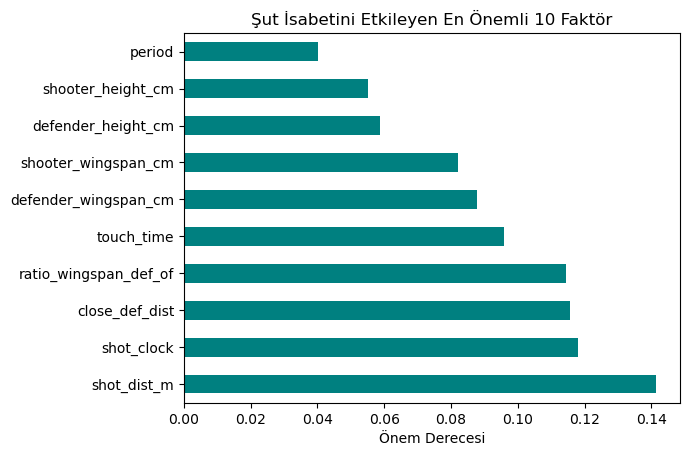

In [168]:
# 6. Test Et
y_pred = rf_model.predict(X_test)

# 7. Sonuçları Göster
print("\n--- Model Başarısı ---")
print("Doğruluk (Accuracy):", accuracy_score(y_test, y_pred))
print("\nSınıflandırma Raporu:\n", classification_report(y_test, y_pred))

# 8. Hangi Özellik En Önemliydi? (Feature Importance)
importance = pd.Series(rf_model.feature_importances_, index=X.columns)
importance.nlargest(10).plot(kind='barh', color='teal')
plt.title("Şut İsabetini Etkileyen En Önemli 10 Faktör")
plt.xlabel("Önem Derecesi")
plt.show()

In [170]:
param_grid = {
    'n_estimators': [100, 200, 500],          # Ağaç sayısı
    'max_depth': [10, 20, 30, None],          # Derinlik (None: Limitsiz)
    'min_samples_split': [2, 5, 10],          # Bölünme için min örnek
    'min_samples_leaf': [1, 2, 4],            # Yaprakta kalacak min örnek
    'max_features': ['sqrt', 'log2']          # Her bölünmede bakılacak özellik sayısı
}

# 2. Modeli ve arama algoritmasını kuralım
rf = RandomForestClassifier(random_state=42)

# RandomizedSearchCV rastgele 20 kombinasyon dener (daha hızlıdır)
rf_random = RandomizedSearchCV(estimator=rf, 
                               param_distributions=param_grid, 
                               n_iter=20,          # 20 farklı kombinasyon dene
                               cv=3,               # 3 katlı çapraz doğrulama yap
                               verbose=2, 
                               random_state=42, 
                               n_jobs=-1)          # Tüm işlemcileri kullan (Hız için)

# 3. Eğitimi Başlat (Biraz sürebilir)
print("En iyi parametreler aranıyor...")
rf_random.fit(X_train, y_train)

En iyi parametreler aranıyor...
Fitting 3 folds for each of 20 candidates, totalling 60 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'max_depth': [10, 20, 30, None],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 500]},
                   random_state=42, verbose=2)

In [171]:
# 4. En iyi sonucu ve parametreleri görelim
print("\nEn İyi Parametreler:", rf_random.best_params_)
print("En İyi Skor (Eğitim Seti İçinde):", rf_random.best_score_)

# 5. Test seti üzerinde son durumu görelim
best_model = rf_random.best_estimator_
y_pred_new = best_model.predict(X_test)

from sklearn.metrics import accuracy_score
print("\nTest Seti Doğruluğu (Yeni):", accuracy_score(y_test, y_pred_new))


En İyi Parametreler: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 10}
En İyi Skor (Eğitim Seti İçinde): 0.6175101090552628

Test Seti Doğruluğu (Yeni): 0.6206347261365028
